In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from pprint import pprint

pd.set_option('expand_frame_repr', False)

In [2]:
animelist = pd.read_csv('animelist.csv')
animelist.shape
animelist.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0


In [3]:
anime = pd.read_csv('anime.csv')
anime.shape
anime.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [4]:
watching = pd.read_csv('watching_status.csv')
watching

,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


In [5]:
syn = pd.read_csv('anime_with_synopsis.csv')
syn.shape
syn.head()

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


### `animelist`: user ratings and watching status
### `anime`: anime info
### `watching`: mapping between watching status and its corresponding number
### `syn`: synopsis of each anime

In [6]:
# add synpnopsis into anime
anime = anime.merge(syn[['MAL_ID', 'sypnopsis']], on = 'MAL_ID', how = 'left')
anime.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,"Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,It is the dark century and the people are suff...


In [7]:
anime.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'sypnopsis'],
      dtype='object')

In [8]:
studio_cnts = anime['Studios'].value_counts()

In [9]:
studio_cnts[:10]

Unknown              7079
Toei Animation        755
Sunrise               479
J.C.Staff             358
Madhouse              324
TMS Entertainment     277
Production I.G        266
Studio Deen           263
Studio Pierrot        249
OLM                   212
Name: Studios, dtype: int64

# EDA and Feature engineering on `anime` dataframe for content-based recommending purpose

### let's take a brief look at how many animes our users usually ''watch'' (in all kinds of senses defined by the `watching` table)

In [10]:
num_anime_watched = animelist.groupby(by = ['user_id'], as_index=False).agg({"anime_id":"count"})

In [11]:
num_anime_watched.head()

,user_id,anime_id
0,0,74
1,1,139
2,2,494
3,3,358
4,4,156


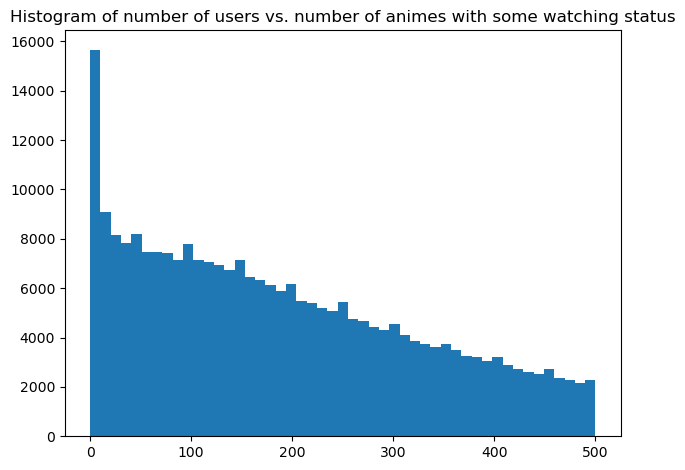

In [12]:
fig, ax = plt.subplots()
bins = np.linspace(0, 500, 50)
n, bins, patches = ax.hist(num_anime_watched['anime_id'], bins, density=False)
ax.set_title('Histogram of number of users vs. number of animes with some watching status')
fig.tight_layout()
plt.show()

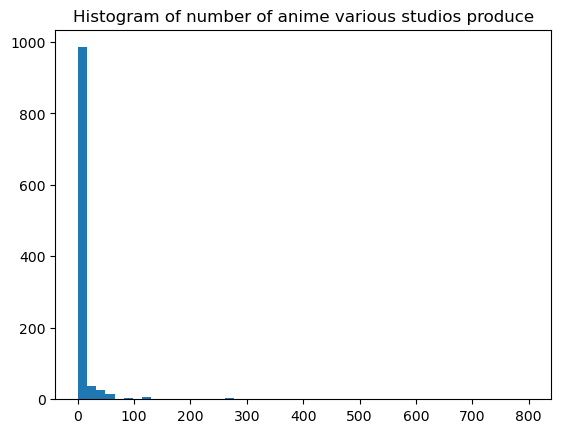

In [13]:
fig1, ax1 = plt.subplots()
bins = np.linspace(0, 800, 50)
n, bins, patches = ax1.hist(list(studio_cnts), bins, density=False)
ax1.set_title('Histogram of number of anime various studios produce')
fig.tight_layout()
plt.show()

In [14]:
len(studio_cnts)

1090

In [15]:
anime[['Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source']].head()

,Aired,Premiered,Producers,Licensors,Studios,Source
0,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original
1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original
2,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga
3,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original
4,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga


Among `Aired`, `Premiered`, `Producers`, `Licensors`, `Studios`, and `Source`, we decided that `Studios` has a strongest effect on the style and quality of an anime. So we keep `Studios` and drop the other columns.

In [16]:
anime_archive = anime.copy()
anime = anime.drop(['Aired', 'Premiered', 'Producers', 'Licensors', 'Source'], axis = 1)

In [17]:
anime.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Studios', 'Duration', 'Rating', 'Ranked',
       'Popularity', 'Members', 'Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Plan to Watch', 'Score-10', 'Score-9', 'Score-8',
       'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2',
       'Score-1', 'sypnopsis'],
      dtype='object')

In [18]:
anime[['Rating', 'Ranked',
       'Popularity', 'Members', 'Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Plan to Watch']].head()

,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
0,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800
1,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964
2,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918
3,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719
4,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394


In this project, we will simply ignore the `rating` of an anime and only focus on the similarity of popularity, genre, and studio. Note that the Index 0 anime `Cowboy Bebop` is a very very nice classic piece (one of my favorites) yet has `popularity` only 39. So maybe `popularity` is some sort of ranking, or it denotes the current popularity. Since the definition of `popularity` is ambiguous, we are gonna ignore it and define new popularity by watching status and `Favorites` & `Members`.

For now we will define the adjusted `Popularity` as `Members` + `Favorites` + `Completed` + 0.5 * `Watching` - `Dropped`. And taking `log` of the number. And we drop the `Ranked` column since we will be only using the adjusted `Popularity` to measure popularity (in terms of number of people).

In [19]:
anime = anime.drop(['Rating', 'Ranked'], axis = 1)

In [20]:
anime['Popularity'] = anime.apply(lambda x: x.Members + x.Favorites + x.Completed + 0.5 * x.Watching - x.Dropped, axis=1)

In [21]:
anime['Popularity'] = anime.apply(lambda x: np.log(x.Popularity), axis = 1)

In [22]:
anime = anime.drop(['Members', 'Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Plan to Watch'], axis = 1)

In [23]:
anime.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Studios', 'Duration', 'Popularity', 'Score-10',
       'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4',
       'Score-3', 'Score-2', 'Score-1', 'sypnopsis'],
      dtype='object')

Since we only care about the `Name` of an anime, we are gonna ignore its `English name` and `Japanese name`.

In [24]:
anime = anime.drop(['English name', 'Japanese name'], axis = 1)

Since the `Score` contains the average score of an anime and we already have `Popularity` measuring the popularity of an anime, we will ignore the `Score-x` columns. We do not care about whether an anime is a movie or a TV series in this project, so we drop `Type`, `Duration` and `Episodes`. Also as we are trying to build a numerical dataframe, we are gonna drop `sypnopsis` as well.

In [25]:
anime = anime.drop(['Type', 'Episodes', 'Duration', 'Score-10',
       'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4',
       'Score-3', 'Score-2', 'Score-1', 'sypnopsis'], axis = 1)

In [26]:
anime.head()

,MAL_ID,Name,Score,Genres,Studios,Popularity
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Sunrise,14.537400
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Bones,13.089744
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Madhouse,13.727750
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Sunrise,11.836508
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Toei Animation,9.891870


In [27]:
anime_archive2 = anime.copy()

### transform `anime` to numerical

In [28]:
genres = set()
for ind, row in anime.iterrows():
    cur = row['Genres'].split(', ')
    genres = genres.union(cur)

nume_genres = {}
for x in genres:
    nume_genres[x] = []

for ind, row in anime.iterrows():
    cur = row['Genres'].split(', ')
    for x in genres:
        if x in cur:
            nume_genres[x].append(1)
        else:
            nume_genres[x].append(0)
for x in genres:
    anime[x] = nume_genres[x]
anime.head()

,MAL_ID,Name,Score,Genres,Studios,Popularity,Comedy,Samurai,Shoujo,Sports,...,Game,Action,Magic,Demons,Shounen,Supernatural,Adventure,Super Power,Dementia,Psychological
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Sunrise,14.537400,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Bones,13.089744,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Madhouse,13.727750,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Sunrise,11.836508,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Toei Animation,9.891870,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0


In [29]:
anime = anime.drop(['Unknown', 'Genres'], axis = 1)

In [30]:
studios = set()
for ind, row in anime.iterrows():
    cur = row['Studios'].split(', ')
    studios = studios.union(cur)

In [31]:
d = {}
for x in studios:
    d[x] = 0
for ind, row in anime.iterrows():
    cur = row['Studios'].split(', ')
    for x in cur:
        d[x] += 1
D = {}
for x in d.keys():
    if d[x] >= 2:
        D[x] = d[x]

In [32]:
nume_studios = {}
for x in D:
    nume_studios[x] = []

for ind, row in anime.iterrows():
    cur = row['Studios'].split(', ')
    for x in D:
        if x in cur:
            nume_studios[x].append(1)
        else:
            nume_studios[x].append(0)

In [33]:
studio_df = pd.DataFrame(nume_studios)
studio_df.head()

,TANOsim,Dazzling Star,Echoes,REALTHING,Opera House,Front Line,Nice Boat Animation,Tonko House,Shanghai Hippo Animation,Welz Animation Studios,...,Studio Kyuuma,Studio Egg,Bouncy,Studio Binzo,Fenz,BUILD DREAM,Namu Animation,AIC,2:10 AM Animation,Marza Animation Planet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
anime = pd.concat([anime, studio_df], axis = 1)
anime.head()

,MAL_ID,Name,Score,Studios,Popularity,Comedy,Samurai,Shoujo,Sports,Vampire,...,Studio Kyuuma,Studio Egg,Bouncy,Studio Binzo,Fenz,BUILD DREAM,Namu Animation,AIC,2:10 AM Animation,Marza Animation Planet
0,1,Cowboy Bebop,8.78,Sunrise,14.537400,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,Bones,13.089744,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,Trigun,8.24,Madhouse,13.727750,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,Witch Hunter Robin,7.27,Sunrise,11.836508,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,Bouken Ou Beet,6.98,Toei Animation,9.891870,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
anime = anime.drop(['Name', 'Studios'], axis = 1)
anime.index = anime['MAL_ID']
anime.head()

,MAL_ID,Score,Popularity,Comedy,Samurai,Shoujo,Sports,Vampire,Drama,Ecchi,...,Studio Kyuuma,Studio Egg,Bouncy,Studio Binzo,Fenz,BUILD DREAM,Namu Animation,AIC,2:10 AM Animation,Marza Animation Planet
MAL_ID,,,,,,,,,,,,,,,,,,,,,
1,1,8.78,14.537400,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,5,8.39,13.089744,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,6,8.24,13.727750,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,7,7.27,11.836508,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,8,6.98,9.891870,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
def convert(x):
    try:
        return float(x)
    except ValueError:
        return 0

In [37]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(0, 3))
anime = anime.drop(['MAL_ID'], axis = 1)
anime = anime.fillna(0)
anime['Score'] = [convert(x) for x in anime['Score']]
#anime['Score'] = [0 if type(row['Score']) == str else row['Score'] for inx, row in anime.iterrows()]
anime['Popularity'] = [0 if type(row['Popularity']) == str else row['Popularity'] for inx, row in anime.iterrows()]
df = pd.DataFrame(scalar.fit_transform(anime))
df.columns = anime.columns
df.index = anime.index
df.head()

,Score,Popularity,Comedy,Samurai,Shoujo,Sports,Vampire,Drama,Ecchi,Kids,...,Studio Kyuuma,Studio Egg,Bouncy,Studio Binzo,Fenz,BUILD DREAM,Namu Animation,AIC,2:10 AM Animation,Marza Animation Planet
MAL_ID,,,,,,,,,,,,,,,,,,,,,
1,2.866159,2.832234,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.738847,2.550196,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.689880,2.674495,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.373232,2.306035,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2.278564,1.927173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## cosine similarity

In [90]:
from numpy import dot
from numpy.linalg import norm 

def recommend_content_based(idx_list, num = 20):
    """
    Content based recommendations.
    Calls the cosine similarity function to calculate similarities and returns the
    most similar movies, excluding the ones listed by the user
    """
    def getInputVec(idx_list):
        '''
        Calculate the mean of the input sequence of vectors
        '''
        s = df.loc[idx_list[0]].values
        for i in range(1,len(idx_list)):
            s += df.loc[idx_list[i]].values
        return [x/len(idx_list) for x in s]
    
    def cosine_sim(v1,v2):
        '''
        Calculates the cosine similarity between two vectors
        '''
        return dot(v1,v2)/(norm(v1)*norm(v2))
    
    inputVec = getInputVec(idx_list) #gets avg values of the idx inputed
    df_rec = df.loc[~df.index.isin(idx_list)] # excludes anime already listed by the user
    df_rec['sim']= df_rec.apply(lambda x: cosine_sim(inputVec, x.values), axis = 1)  #goes through all the anime vectors in the table
                                                         #and creates a column containing the values of the cosine similarity
    
    idxs = df_rec.nlargest(num, columns='sim').index # gets only the num most similars 
    # res = basics_plain.loc[basics_plain['tconst'].isin(idxs)]
    # returns up to num similar moviess that the user didnt list already
    return list(idxs)

# Now collaborative filtering on `animelist` table

In [39]:
watching

,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


In this project we are gonna only care about `completed` ratings (i.e. delete other records). For the same reason, we ignore `watched_episodes` as well. We again will consider rating < 5 as negative, and rating > 5 as positive.

In [40]:
animelist.shape

(109224747, 5)

In [41]:
animelist.columns

Index(['user_id', 'anime_id', 'rating', 'watching_status', 'watched_episodes'], dtype='object')

In [42]:
animelist = animelist.loc[animelist.watching_status.isin([2])]
animelist = animelist[['user_id', 'anime_id', 'rating']]
animelist.shape

(68089751, 3)

We ignore records that did not receive a rating for simplicity.

In [43]:
animelist = animelist.loc[~animelist.rating.isin([0])]
animelist.shape

(57633278, 3)

The size is too large for my computer to process. So I will only keep the high ratings.

In [44]:
animelist = animelist.loc[animelist.rating.isin([10])]
animelist.shape

(6716048, 3)

Since we only keep records with rating 10, we convert thoses 10's to 1's for computation simplicity.

In [45]:
animelist['rating']= animelist.apply(lambda x: 1, axis = 1)
animelist.head()

,user_id,anime_id,rating
19,0,1571,1
20,0,578,1
48,0,2236,1
49,0,415,1
107,1,1575,1


In [46]:
# pivot and create movie-user matrix
user_to_anime_df = animelist.pivot(
    index = 'user_id',
     columns = 'anime_id',
      values = 'rating').fillna(0)

user_to_anime_df.head()

/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_1656/2691451078.py:2: PerformanceWarning: The following operation may generate 4778488110 cells in the resulting pandas object.
  user_to_anime_df = animelist.pivot(


anime_id,1,5,6,7,8,15,16,17,18,19,...,45598,45753,46000,46491,47307,47398,47402,47614,47616,48456
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
anime_list = list(user_to_anime_df.columns)

In [47]:
# transform matrix to scipy sparse matrix
user_to_anime_sparse_df = csr_matrix(user_to_anime_df.values)
user_to_anime_sparse_df

<291549x16390 sparse matrix of type '<class 'numpy.float64'>'
	with 6716048 stored elements in Compressed Sparse Row format>

## fit KNN

In [48]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_anime_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [49]:
animelist.head()

,user_id,anime_id,rating
19,0,1571,1
20,0,578,1
48,0,2236,1
49,0,415,1
107,1,1575,1


In [51]:
anime_archive.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,"Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,It is the dark century and the people are suff...


## Build final recommender

In [98]:
def countList(lst1, lst2):
    if len(lst1) > len(lst2):
        return countList(lst2, lst1)
    n = len(lst1)
    return [sub[item] for item in range(n)
                      for sub in [lst1, lst2[:n]]] + lst2[n:]

In [105]:
def recommender_hybrid(user_id, n_similar_users = 5, n_movies = 10): 
    
    # print history of the specified user 
    print("Animes rated 10 by User {}:".format(user_id)) 
    watched_id = list(animelist.loc[animelist['user_id'] == user_id]['anime_id']) # anime ids
    pprint(anime_archive.loc[anime_archive['MAL_ID'].isin(watched_id)][['MAL_ID', 'Name', 'Score', 'Type', 'Source', 'sypnopsis']])
    print("")

    # function to find top n similar users of the given input user 
    def get_similar_users(user, n = n_similar_users):
        ## input to this function is the user and number of top similar users you want.

        knn_input = np.asarray([user_to_anime_df.values[user]])  #.reshape(1,-1)
        # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
        distances, indices = knn_model.kneighbors(knn_input, n_neighbors = n + 1)
  
        print("Top", n, "users who are very much similar to the User-", user, "are: ")
        print(" ")
        for i in range(1,len(distances[0])):
            print(i, ". User:", indices[0][i]+1, "separated by distance of", distances[0][i])
        return indices.flatten()[1:], distances.flatten()[1:]

    # get similar users and the movies they like
    similar_user_list, distance_list = get_similar_users(user_id, n_similar_users)
    mov_rtngs_sim_users = user_to_anime_df.values[similar_user_list]
    # give more weight to more similar users
    weightage_list = np.exp(1 - distance_list)/np.sum(np.exp(1 - distance_list))
    weightage_list = weightage_list[:,np.newaxis] + np.zeros(mov_rtngs_sim_users.shape[1])
    new_rating_matrix = weightage_list * mov_rtngs_sim_users
    mean_rating_list = new_rating_matrix.sum(axis = 0) # initial weights
    
    # get corresponding movie Ids from their indices in user_to_anime matrix
    def get_ids(indices):
        return [anime_list[i] for i in indices]
    
    def filtered_anime_recommendations(n = n_movies):
  
        #first_zero_index = np.where(mean_rating_list == 0)[0][-1]
        sortd_index = np.argsort(mean_rating_list)[::-1]
        mean_rating_list_sorted = sorted(mean_rating_list)[::-1]
        #sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
        count = 0
        indices = []
        for index, weight in zip(sortd_index, mean_rating_list_sorted):
            if count >= n or weight == 0: 
                break
            indices.append(index)
            count += 1
        
        return get_ids(indices)

    ids1 = filtered_anime_recommendations(n_movies)
    ids2 = recommend_content_based(watched_id, n_movies)
    ids = countList(ids1, ids2)
    
    # filter out the already watched movies
    count = 0
    filtered_ids = []
    for x in ids:
        if x not in watched_id:
            filtered_ids.append(x)
    
    print("")
    print("Movies recommended based on similar users are: ")
    print("")   
    pprint(anime_archive.loc[anime_archive['MAL_ID'].isin(filtered_ids[:n_movies])][['MAL_ID', 'Name', 'Score', 'Type', 'Source', 'sypnopsis']])      

In [106]:
recommender_hybrid(0)

Animes rated 10 by User 0:
      MAL_ID                   Name Score   Type        Source                                          sypnopsis
388      415   Tonari no Yamada-kun  7.19  Movie  4-koma manga  Join in the adventures of the quirky Yamada fa...
542      578         Hotaru no Haka  8.51  Movie         Novel  s World War II reaches its conclusion in 1945,...
1427    1571             Ghost Hunt  7.81     TV   Light novel  hile at school, Taniyama Mai and her friends l...
2049    2236  Toki wo Kakeru Shoujo   8.2  Movie         Novel  akoto Konno is in her last year of high school...

Top 5 users who are very much similar to the User- 0 are: 
 
1 . User: 225877 separated by distance of 0.29289321881345254
2 . User: 150964 separated by distance of 0.29289321881345254
3 . User: 40209 separated by distance of 0.42264973081037416
4 . User: 210728 separated by distance of 0.42264973081037416
5 . User: 88737 separated by distance of 0.42264973081037416

Movies recommended based on simi

/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_1656/4212916383.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['sim']= df_rec.apply(lambda x: cosine_sim(inputVec, x.values), axis = 1)  #goes through all the anime vectors in the table


In [108]:
recommender_hybrid(7)

Animes rated 10 by User 7:
      MAL_ID                              Name Score   Type        Source                                          sypnopsis
176      199     Sen to Chihiro no Kamikakushi  8.83  Movie      Original  Stubborn, spoiled, and naïve, 10-year-old Chih...
3537    4181              Clannad: After Story  8.96     TV  Visual novel  Clannad: After Story , the sequel to the criti...
3971    5114  Fullmetal Alchemist: Brotherhood  9.19     TV         Manga  "In order for something to be obtained, someth...
5846    9617                       K-On! Movie  8.33  Movie  4-koma manga  Graduation looms for the founding members of t...
6092   10162                        Usagi Drop  8.43     TV         Manga  Daikichi Kawachi is a 30-year-old bachelor wor...
7036   13759       Sakura-sou no Pet na Kanojo  8.19     TV   Light novel  hen abandoned kittens and his good conscience ...

Top 5 users who are very much similar to the User- 7 are: 
 
1 . User: 224957 separated by distan

/var/folders/7x/mknq0g2s07jdkg8524w7snh40000gn/T/ipykernel_1656/4212916383.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['sim']= df_rec.apply(lambda x: cosine_sim(inputVec, x.values), axis = 1)  #goes through all the anime vectors in the table
